In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from networks_2022 import BranchedNetwork
from data.CleanSoundsDataset import CleanSoundsDataset
from data.NoisyDataset import NoisyDataset

# Parameters

In [2]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
checkpoints_dir = f'{engram_dir}checkpoints/'
tensorboard_dir = f'{engram_dir}tensorboard/'
activations_dir = f'{engram_dir}activations_CF/'

In [3]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cuda:0


# Reconstruction evaluation functions

In [4]:
def row_rms(A, B, do_compare_rows=True):
    """
    RMS the rows of a matrix

    given A, B, returns vector of pearson correleation coefficients where r[ii] = corr(A[:,ii],B[:,ii])
    """
    
    if torch.is_tensor(A):
        A = A.numpy()
    if torch.is_tensor(B):
        B = B.numpy()
    A = A.squeeze()
    B = B.squeeze()

    if do_compare_rows:
        A, B = A.T, B.T
        
    stim = (A.astype(float)-B.astype(float)) 
    out = np.sqrt(np.mean(stim * stim, axis = 0))

    return np.mean(out)

In [5]:
def pearson(A, B):
    corr, _ = pearsonr(A.flatten(), B.flatten())
    return corr

# Function to collect reconstruction values

In [6]:
def eval_correlations(
    results, dset, corr_func,
    exclude_correct=True, exclude_incorrect=False
    ):
    
    idxs = np.ones(dset.n_data).astype(bool)
    if exclude_correct:
        idxs = np.logical_and(idxs, dset.net_mistakes)
    if exclude_incorrect:
        idxs = np.logical_and(idxs, np.logical_not(dset.net_mistakes))
    idxs = np.argwhere(idxs).squeeze()
    timesteps = []
    correlations = []
    
    n_timesteps = 5
    for i in idxs:
        clean_input = dset.clean_in[i].reshape((164, 400))
        label = results['label'][i]
        for t in range(n_timesteps):
            reconstruction = results[f'{t}_reconstructions'][i]
            corr = corr_func(reconstruction, clean_input)
            timesteps.append(t)
            correlations.append(corr)
            
    return timesteps, correlations

# Auditory Background, Incorrect

In [7]:
# This is bad practice! But the warnings are real annoying
import warnings
warnings.filterwarnings("ignore")

In [8]:
bgs = ['AudScene', 'Babble8Spkr']
snrs = [-6.0, -3.0, 0.0, 3.0]

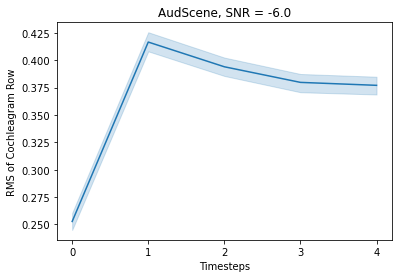

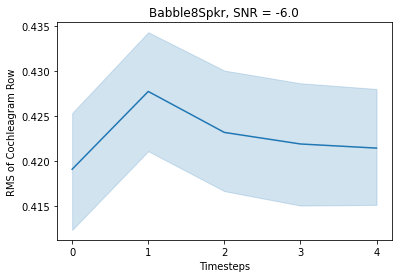

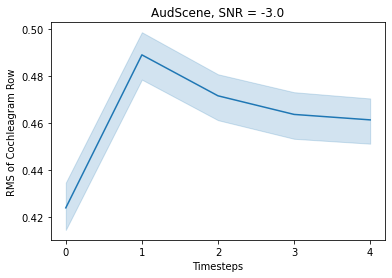

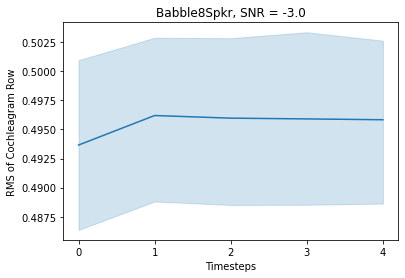

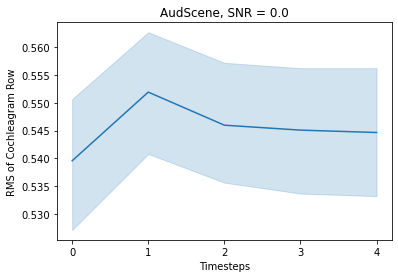

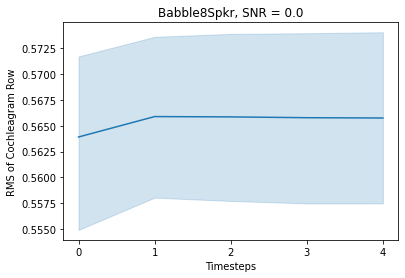

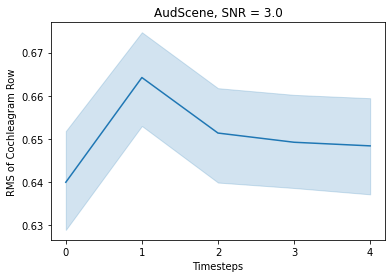

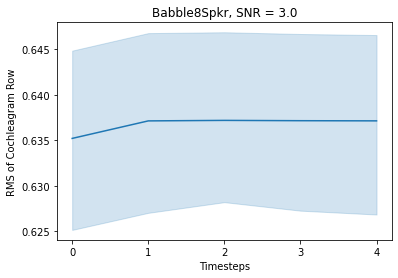

In [9]:
for snr in snrs:
    for bg in bgs:
        dset = NoisyDataset(bg, snr)
        results_path = f'{activations_dir}{bg}_snr{int(snr)}.hdf5'
        results = h5py.File(results_path, 'r')
        timesteps, corrs = eval_correlations(results, dset, row_rms)
        df = pd.DataFrame({
            'Timesteps': timesteps, 'Correlation': corrs
            })
        g = sns.lineplot(x='Timesteps', y='Correlation', data=df)
        plt.title(f'{bg}, SNR = {snr}')
        plt.ylabel('RMS of Cochleagram Row')
        plt.xticks([0, 1, 2, 3, 4])
        plt.show(g)

# Auditory Background, Correct

In [10]:
# This is bad practice! But the warnings are real annoying
import warnings
warnings.filterwarnings("ignore")

In [11]:
bgs = ['AudScene', 'Babble8Spkr']
snrs = [-6.0, -3.0, 0.0, 3.0]

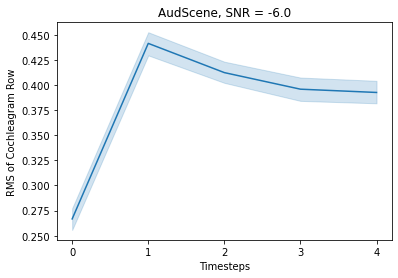

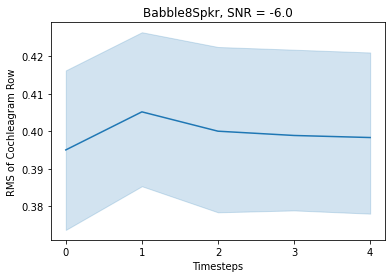

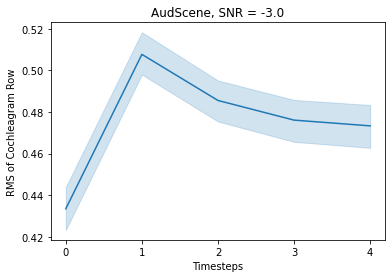

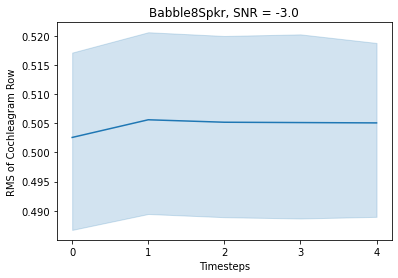

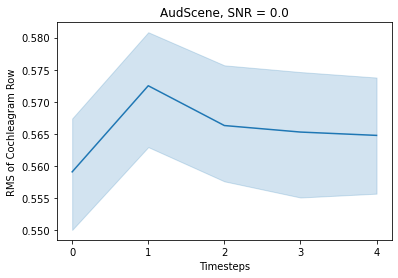

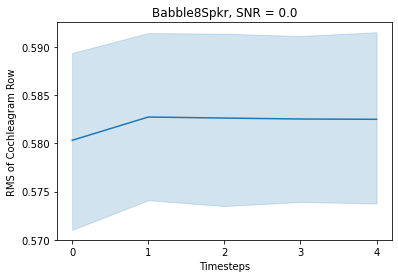

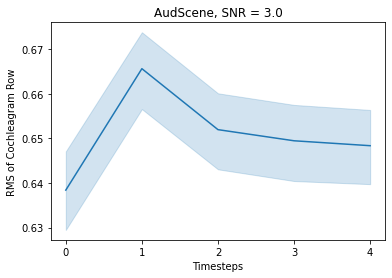

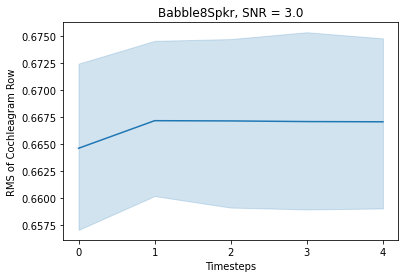

In [12]:
for snr in snrs:
    for bg in bgs:
        dset = NoisyDataset(bg, snr)
        results_path = f'{activations_dir}{bg}_snr{int(snr)}.hdf5'
        results = h5py.File(results_path, 'r')
        timesteps, corrs = eval_correlations(
            results, dset, row_rms,
            exclude_correct=False, exclude_incorrect=True
            )
        df = pd.DataFrame({
            'Timesteps': timesteps, 'Correlation': corrs
            })
        g = sns.lineplot(x='Timesteps', y='Correlation', data=df)
        plt.title(f'{bg}, SNR = {snr}')
        plt.ylabel('RMS of Cochleagram Row')
        plt.xticks([0, 1, 2, 3, 4])
        plt.show(g)